## DATASET

In [1]:
import numpy as np
from tensorflow.keras.datasets import mnist, fashion_mnist
import matplotlib.pyplot as plt

Loading the MNIST and Fashion MNIST dataset

In [3]:
(mnist_x_train, mnist_y_train), (mnist_x_test, mnist_y_test) = mnist.load_data()
(fashion_mnist_x_train, fashion_mnist_y_train), (fashion_mnist_x_test, fashion_mnist_y_test) = fashion_mnist.load_data()
print()

print('Shape MNIST train:', np.shape(mnist_x_train))
print('Shape Fashion MNIST train:', np.shape(fashion_mnist_x_train))
print()

# Normalization and Padding
mnist_x_train = np.pad(mnist_x_train,((0,0),(2,2),(2,2)))/255.
mnist_x_test = np.pad(mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape MNIST train after padding:', np.shape(mnist_x_train))
fashion_mnist_x_train = np.pad(fashion_mnist_x_train,((0,0),(2,2),(2,2)))/255.
fashion_mnist_x_test = np.pad(fashion_mnist_x_test,((0,0),(2,2),(2,2)))/255.
print('Shape Fashion MNIST train after padding:', np.shape(mnist_x_train))


Shape MNIST train: (60000, 28, 28)
Shape Fashion MNIST train: (60000, 28, 28)

Shape MNIST train after padding: (60000, 32, 32)
Shape Fashion MNIST train after padding: (60000, 32, 32)


In [ ]:
print(f'Number of MNIST/fashion MNIST training samples: {np.shape(mnist_x_train)[0]}')
print(f'Number of MNIST/fashion MNIST test samples: {np.shape(mnist_x_test)[0]}')
print(f'MNIST/fashion MNIST resolution: {np.shape(mnist_x_test)[1:]}')

Number of MNIST/fashion MNIST training samples: 60000
Number of MNIST/fashion MNIST test samples: 10000
MNIST/fashion MNIST resolution: (32, 32)


Only one channel (grey-scale images).

In [4]:
N_train, h, w = mnist_x_train.shape[0], mnist_x_train.shape[1], mnist_x_train.shape[2]
N_test = mnist_x_test.shape[0]

### Data generator
Generator which generates batches. A batch is a couple `x_batch, y_batch`, containing `batchsize` number of samples. `x_batch` represents the input, and it contains images `x`: each image `x` has spatial dimensions $32*32$ and it contains a pair of MNIST-fashion MNIST images added together. `y_batch` represents the ground truth, and it contains the images `y`: each image `y` has spatial dimensions $32*64$ and it contains the same pair of MNIST-fashion MNIST images concatenated along the width.

In [5]:
def datagenerator(x1, x2, batchsize):
    # x1: first dataset of images. In our case, MNIST dataset (either train or test)
    # x2: second dataset of images. In our case, fashion MNIST dataset (either train or test)

    n1 = x1.shape[0]
    n2 = x2.shape[0]
    while True:
        num1 = np.random.randint(0, n1, batchsize)
        num2 = np.random.randint(0, n2, batchsize)

        x_batch = (x1[num1] + x2[num2]) / 2.0
        y_batch = np.concatenate((x1[num1], x2[num2]), axis=2)

        yield x_batch, y_batch 

In [6]:
batchsize = 64

In [7]:
# Generator for creating the training batches
train_generator = datagenerator(mnist_x_train, fashion_mnist_x_train, batchsize)

# Generator for creating the validation batches
test_generator = datagenerator(mnist_x_test, fashion_mnist_x_test, batchsize)

Example of a training batch

In [ ]:
x_batch, y_batch = next(train_generator)
print('Shape of the x_batch:', x_batch.shape)
print('Shape of the y_batch:', y_batch.shape)

Shape of the x_batch: (64, 32, 32)
Shape of the y_batch: (64, 32, 64)


The data is already normalized into $[0,1]$

In [ ]:
x_batch[0].min(), x_batch[0].max()

(0.0, 0.8313725490196078)

In [ ]:
y_batch[0].min(), y_batch[0].max()

(0.0, 1.0)

Visualization of a sample in the batch

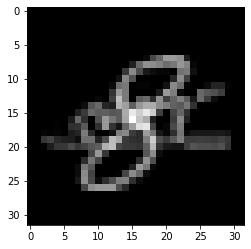

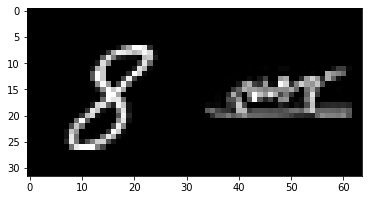

In [ ]:
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()

## MODEL
Fully convolutional autoencoder. One single encoder, and two decoder: one for producing the MNIST image, and one for producing the fashion MNIST image. Input: $32*32*1$. Two outputs $32*32*1$, which are concatenated together along the width, producing a single output $32*64*1$. Convolutional autoencoder with two branches.

In [8]:
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Concatenate
from tensorflow.keras import Model

In [ ]:
def build_model():
  # Dimensions of the input: 32*32*1=1024
  xin = Input(shape=(32,32,1))

  # ENCODER
  x = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(xin)
  x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
  # Latent encoding dimensions: 4*4*64=1024
  x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)

  # FIRST DECODER, for prodcuing the MNIST image
  x1 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
  x1 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x1)
  # Dimensions of the image: 32*32*1
  x1 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x1)

  # SECOND DECODER, for prodcuing the fashion MNIST image
  x2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
  x2 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x2)
  # Dimensions of the image: 32*32*1
  x2 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x2)

  # Dimensions of the output: 32*64*1. Concatenation along the width.
  y = Concatenate(axis=2)([x1,x2])

  nn = Model(inputs=xin, outputs=y)

  return nn

In [10]:
nn = build_model()

In [10]:
nn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 16)   160         ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 32)     4640        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 64)     18496       ['conv2d_1[0][0]']               
                                                                                              

### Training

In [10]:
from tensorflow.keras.optimizers import Adam

In [12]:
nn.compile(optimizer=Adam(), loss='mse')

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint

callback_checkpoint = ModelCheckpoint('CNN_improved.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [115]:
steps_per_epoch = math.floor(N_train / batchsize)
val_steps = math.floor(N_test / batchsize)

In [15]:
hist = nn.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 18s 7ms/step - loss: 0.0462 - val_loss: 0.0191
Epoch 2/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0170 - val_loss: 0.0159
Epoch 3/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0153 - val_loss: 0.0148
Epoch 4/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0143 - val_loss: 0.0141
Epoch 5/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 6/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 7/15
937/937 [==============================] - 7s 7ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 8/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0132 - val_loss: 0.0132
Epoch 9/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 10/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0129 - val_loss: 0.013

Score: around $0.0125$. Better than before.

In [53]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

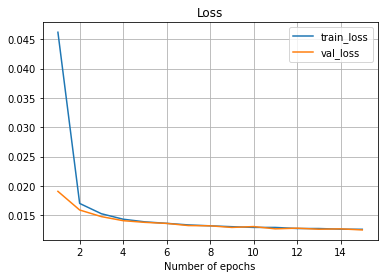

In [19]:
plot_history(hist)

Very smooth curve: no overfitting

### Visualization of some results

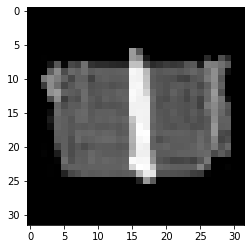

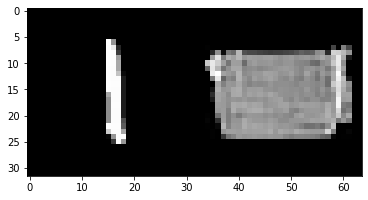

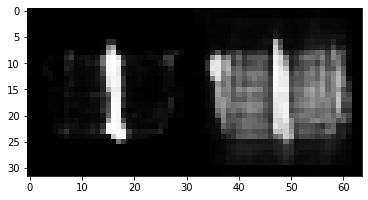

In [27]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

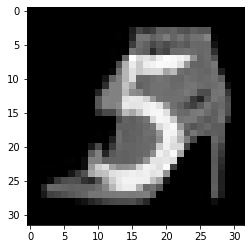

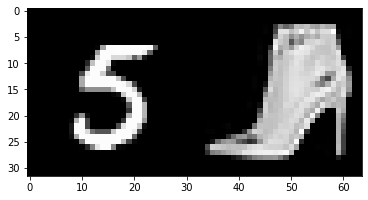

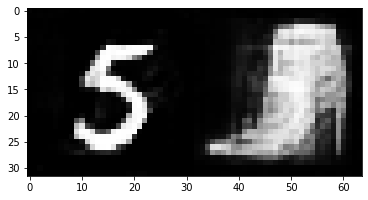

In [28]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

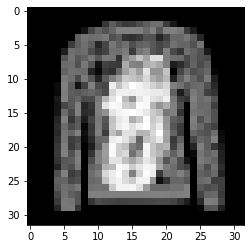

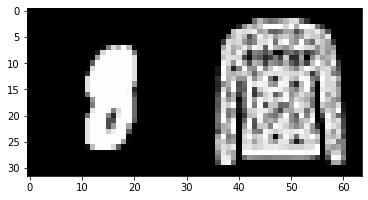

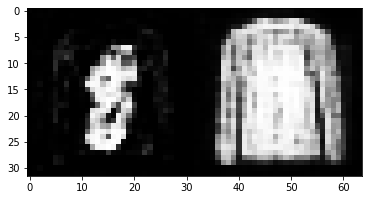

In [29]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

### More training

In [ ]:
nn = build_model()

In [11]:
from tensorflow.keras.optimizers import Adam

In [12]:
nn.compile(optimizer=Adam(), loss='mse')

In [13]:
from tensorflow.keras.callbacks import ModelCheckpoint
callback_checkpoint = ModelCheckpoint('CNN_improved.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [14]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [15]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 18s 7ms/step - loss: 0.0524 - val_loss: 0.0195
Epoch 2/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0174 - val_loss: 0.0160
Epoch 3/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0154 - val_loss: 0.0147
Epoch 4/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0145 - val_loss: 0.0140
Epoch 5/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0139 - val_loss: 0.0138
Epoch 6/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0136 - val_loss: 0.0136
Epoch 7/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0134 - val_loss: 0.0133
Epoch 8/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0132 - val_loss: 0.0131
Epoch 9/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0131 - val_loss: 0.0131
Epoch 10/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0130 - val_loss: 0.012

No improvement...

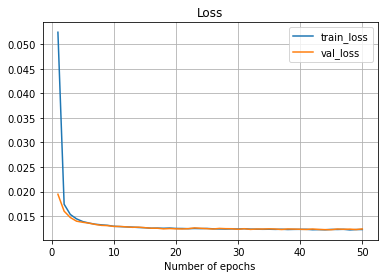

In [18]:
plot_history(hist)

We have reached a plateau...

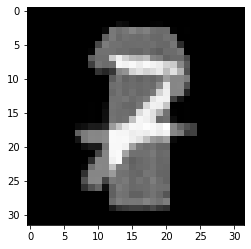

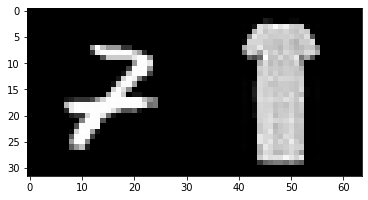

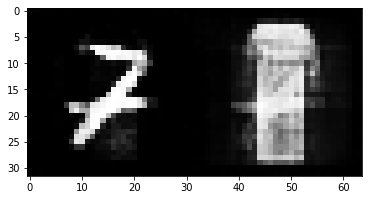

In [19]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

### More training, with `reduceLRonPlateau`

In [ ]:
nn = build_model()

In [23]:
from tensorflow.keras.optimizers import Adam

In [24]:
nn.compile(optimizer=Adam(), loss='mse')

In [25]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(patiente=3)
callback_checkpoint = ModelCheckpoint('CNN_improved.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [26]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [27]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 8s 7ms/step - loss: 0.0516 - val_loss: 0.0195 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0175 - val_loss: 0.0161 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0155 - val_loss: 0.0150 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0145 - val_loss: 0.0142 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0139 - val_loss: 0.0137 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0136 - val_loss: 0.0135 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0134 - val_loss: 0.0132 - lr: 0.0010
Epoch 8/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0132 - val_loss: 0.0131 - lr: 0.0010
Epoch 9/50
937/937 [==============================] - 6s 7ms/step - loss: 0.0131 - val_loss: 0.0

Little improvement: score $0.0122$. Let's train more.

In [33]:
hist = nn.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 6s 7ms/step - loss: 0.0122 - val_loss: 0.0122 - lr: 1.0000e-05
Epoch 2/15
937/937 [==============================] - 6s 7ms/step - loss: 0.0121 - val_loss: 0.0122 - lr: 1.0000e-05
Epoch 3/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0121 - val_loss: 0.0122 - lr: 1.0000e-05
Epoch 4/15
937/937 [==============================] - 6s 7ms/step - loss: 0.0121 - val_loss: 0.0121 - lr: 1.0000e-05
Epoch 5/15
937/937 [==============================] - 6s 7ms/step - loss: 0.0122 - val_loss: 0.0122 - lr: 1.0000e-05
Epoch 6/15
937/937 [==============================] - 6s 7ms/step - loss: 0.0121 - val_loss: 0.0122 - lr: 1.0000e-05
Epoch 7/15
937/937 [==============================] - 6s 6ms/step - loss: 0.0121 - val_loss: 0.0121 - lr: 1.0000e-05
Epoch 8/15
937/937 [==============================] - 6s 7ms/step - loss: 0.0122 - val_loss: 0.0122 - lr: 1.0000e-05
Epoch 9/15
937/937 [==============================] - 6s 7ms/ste

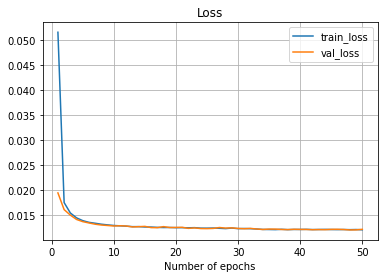

In [29]:
plot_history(hist)

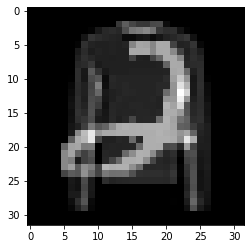

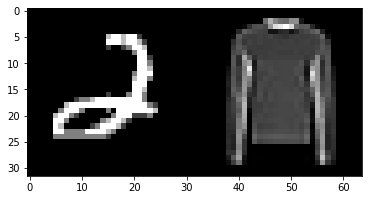

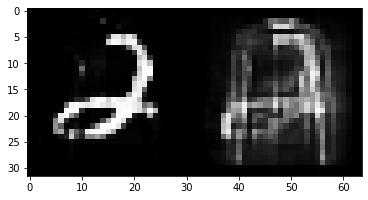

In [30]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

### Let's try a different `reduceLRonPlateau` strategy.

In [34]:
nn = build_model()

In [35]:
from tensorflow.keras.optimizers import Adam

In [36]:
nn.compile(optimizer=Adam(), loss='mse')

In [37]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('CNN_improved.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [38]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [39]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0467 - val_loss: 0.0194 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0173 - val_loss: 0.0160 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0155 - val_loss: 0.0148 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0144 - val_loss: 0.0143 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0139 - val_loss: 0.0137 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0136 - val_loss: 0.0135 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0133 - val_loss: 0.0134 - lr: 0.0010
Epoch 8/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0131 - val_loss: 0.0132 - lr: 0.0010
Epoch 9/50
937/937 [==============================] - 6s 6ms/step - loss: 0.0130 - val_loss: 0.0

No improvement

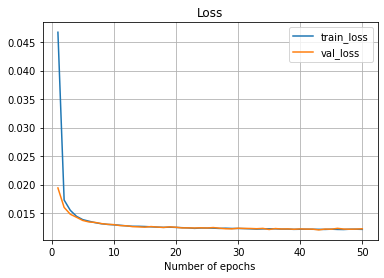

In [42]:
plot_history(hist)

## MORE COMPLEX NETWORK (under 400k parameters)

In [9]:
# Dimensions of the input: 32*32*1=1024
xin = Input(shape=(32,32,1))

# ENCODER
x = Conv2D(filters=8, kernel_size=3, strides=2, padding='same')(xin)
x = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(x)
x = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(x)
# Latent encoding dimensions: 2*2*64=512
x = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(x)

# FIRST DECODER, for prodcuing the MNIST image
x1 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x1 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x1)
x1 = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same')(x1)
# Dimensions of the image: 32*32*1
x1 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x1)

# SECOND DECODER, for prodcuing the fashion MNIST image
x2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x)
x2 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x2)
x2 = Conv2DTranspose(filters=8, kernel_size=3, strides=2, padding='same')(x2)
# Dimensions of the image: 32*32*1
x2 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x2)

# Dimensions of the output: 32*64*1. Concatenation along the width.
y = Concatenate(axis=2)([x1,x2])

nn = Model(inputs=xin, outputs=y)

In [10]:
nn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 16, 16, 8)    80          ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 8, 8, 16)     1168        ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 4, 4, 32)     4640        ['conv2d_1[0][0]']               
                                                                                              

In [48]:
from tensorflow.keras.optimizers import Adam

In [49]:
nn.compile(optimizer=Adam(), loss='mse')

In [50]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('CNN_improved1.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [51]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [52]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 8s 7ms/step - loss: 0.0371 - val_loss: 0.0200 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0171 - val_loss: 0.0150 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0142 - val_loss: 0.0133 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0129 - val_loss: 0.0125 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0123 - val_loss: 0.0119 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0118 - val_loss: 0.0116 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0115 - val_loss: 0.0113 - lr: 0.0010
Epoch 8/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0111 - val_loss: 0.0108 - lr: 0.0010
Epoch 9/50
937/937 [==============================] - 7s 7ms/step - loss: 0.0109 - val_loss: 0.0

Improvement: score $0.0093$.

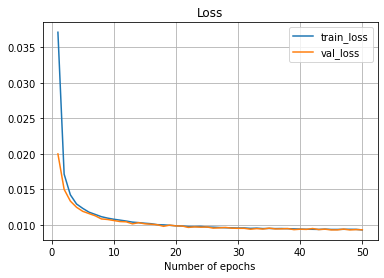

In [54]:
plot_history(hist)

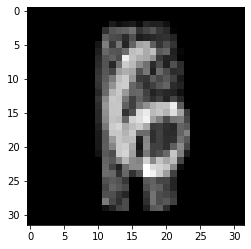

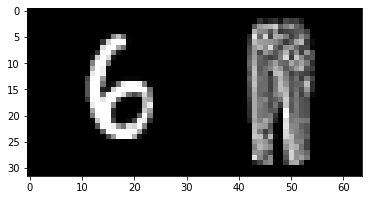

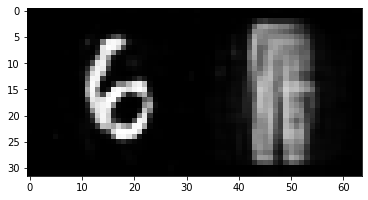

In [55]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

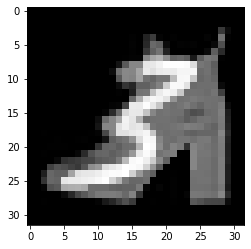

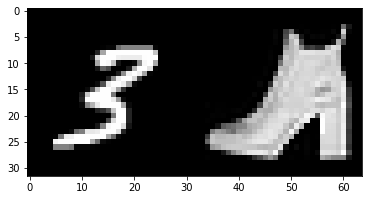

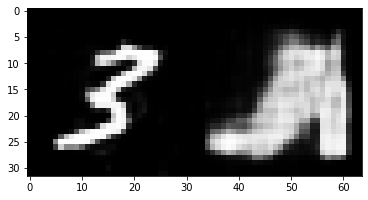

In [56]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

### Further more complex network: adding skip connections

In [11]:
from tensorflow.keras.layers import concatenate

In [12]:
# Dimensions of the input: 32*32*1=1024
xin = Input(shape=(w,h,1))

# ENCODER
xa = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(xin)
xb = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(xa)
xc = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(xb)
# Latent encoding dimensions: 2*2*128=1024
x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(xc)

# FIRST DECODER, for prodcuing the MNIST image
x1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x1 = concatenate([x1,xc])  # Skip connection
x1 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x1)
x1 = concatenate([x1,xb])  # Skip connection
x1 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x1)
x1 = concatenate([x1,xa])  # Skip connection
# Dimensions of the image: 32*32*1
x1 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x1)

# SECOND DECODER, for prodcuing the fashion MNIST image
x2 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x2 = concatenate([x2,xc])  # Skip connection
x2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x2)
x2 = concatenate([x2,xb])  # Skip connection
x2 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x2)
x2 = concatenate([x2,xa])  # Skip connection
# Dimensions of the image: 32*32*1
x2 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x2)

# Dimensions of the output: 32*64*1. Concatenation along the width.
y = Concatenate(axis=2)([x1,x2])

nn = Model(inputs=xin, outputs=y)

In [13]:
nn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 16, 16, 16)   160         ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 8, 8, 32)     4640        ['conv2d_4[0][0]']               
                                                                                                  
 conv2d_6 (Conv2D)              (None, 4, 4, 64)     18496       ['conv2d_5[0][0]']               
                                                                                            

In [14]:
from tensorflow.keras.optimizers import Adam

In [15]:
nn.compile(optimizer=Adam(), loss='mse')

In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('CNN_improved2.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [130]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [65]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0268 - val_loss: 0.0100 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 9s 10ms/step - loss: 0.0089 - val_loss: 0.0081 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 8s 9ms/step - loss: 0.0078 - val_loss: 0.0075 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 8s 9ms/step - loss: 0.0074 - val_loss: 0.0072 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 8s 9ms/step - loss: 0.0072 - val_loss: 0.0071 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 8s 9ms/step - loss: 0.0071 - val_loss: 0.0070 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - 8s 9ms/step - loss: 0.0070 - val_loss: 0.0069 - lr: 0.0010
Epoch 8/50
937/937 [==============================] - 8s 9ms/step - loss: 0.0069 - val_loss: 0.0069 - lr: 0.0010
Epoch 9/50
937/937 [==============================] - 8s 9ms/step - loss: 0.0068 - val_loss: 

Improvement: $0.0062$.

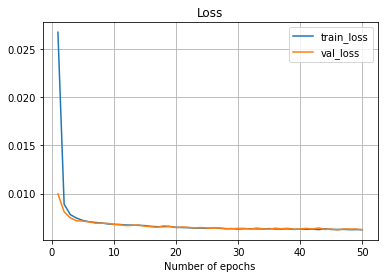

In [67]:
plot_history(hist)

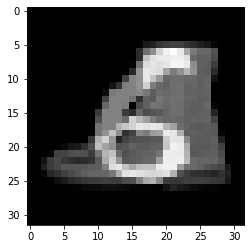

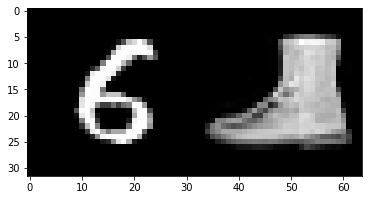

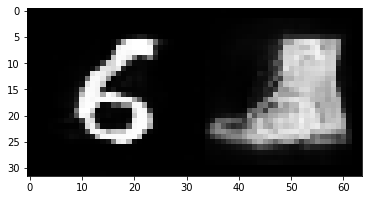

In [68]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

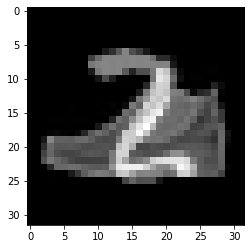

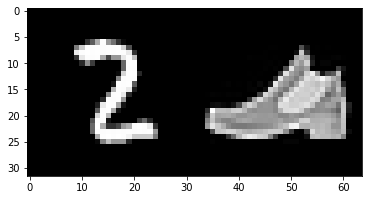

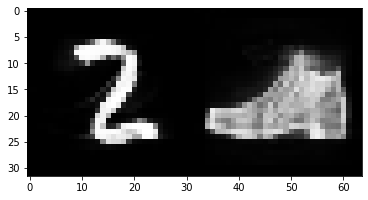

In [69]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

## FURTHER MORE COMPLEX NETWORK (over 400k parameters)

In [20]:
from tensorflow.keras.layers import concatenate, Dropout
from tensorflow.keras import regularizers

In [46]:
# 32*32*1=1024
xin = Input(shape=(w,h,1))

xa = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(xin)
xa = Conv2D(filters=16, kernel_size=3, strides=1, padding='same')(xa)
xa = Dropout(0.2)(xa)
xb = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(xa)
xb = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(xb)
xb = Dropout(0.2)(xb)
xc = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(xb)
xc = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(xc)
xc = Dropout(0.2)(xc)
# 2*2*128=2048
x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(xc)

x1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x1 = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(x1)
#x1 = Dropout(0.2)(x1)
x1 = concatenate([x1,xc])
x1 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x1)
x1 = Conv2DTranspose(filters=32, kernel_size=3, strides=1, padding='same')(x1)
#x1 = Dropout(0.2)(x1)
x1 = concatenate([x1,xb])
x1 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x1)
x1 = Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='same')(x1)
#x1 = Dropout(0.2)(x1)
x1 = concatenate([x1,xa])
x1 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x1)

x2 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
x2 = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(x2)
x2 = Dropout(0.2)(x2)
x2 = concatenate([x2,xc])
x2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = Conv2DTranspose(filters=32, kernel_size=3, strides=1, padding='same')(x2)
x2 = Dropout(0.2)(x2)
x2 = concatenate([x2,xb])
x2 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='same')(x2)
x2 = Dropout(0.2)(x2)
x2 = concatenate([x2,xa])
x2 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x2)

# 32*64*1
y = Concatenate(axis=2)([x1,x2])

nn = Model(inputs=xin, outputs=y)

In [22]:
nn.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_8 (Conv2D)              (None, 16, 16, 16)   160         ['input_3[0][0]']                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 16, 16, 16)   2320        ['conv2d_8[0][0]']               
                                                                                                  
 dropout (Dropout)              (None, 16, 16, 16)   0           ['conv2d_9[0][0]']               
                                                                                            

In [23]:
from tensorflow.keras.optimizers import Adam

In [47]:
nn.compile(optimizer=Adam(), loss='mse')

In [48]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('CNN_improved3.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [49]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [50]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 13s 12ms/step - loss: 0.0648 - val_loss: 0.0537 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 11s 12ms/step - loss: 0.0526 - val_loss: 0.0530 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 12s 13ms/step - loss: 0.0513 - val_loss: 0.0512 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 11s 12ms/step - loss: 0.0514 - val_loss: 0.0510 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 11s 12ms/step - loss: 0.0506 - val_loss: 0.0505 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 11s 12ms/step - loss: 0.0505 - val_loss: 0.0512 - lr: 0.0010
Epoch 7/50
937/937 [==============================] - 11s 11ms/step - loss: 0.0503 - val_loss: 0.0502 - lr: 0.0010
Epoch 8/50
937/937 [==============================] - 11s 11ms/step - loss: 0.0502 - val_loss: 0.0499 - lr: 0.0010
Epoch 9/50
937/937 [==============================] - 11s 12ms/step - loss: 0.05

The MSE remains stucked at $0.049$...

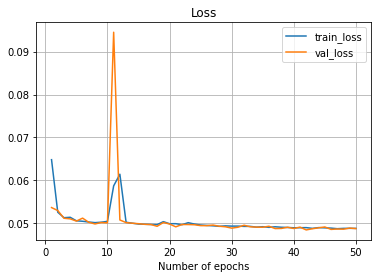

In [54]:
plot_history(hist)

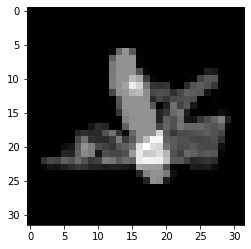

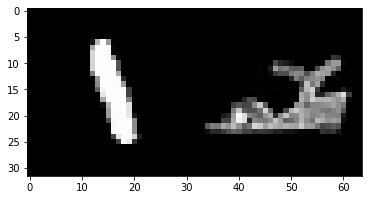

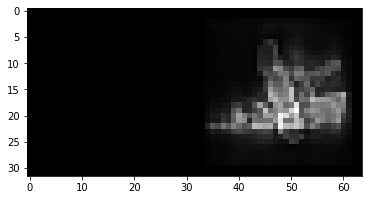

In [52]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

The fashion MNIST image is well generated, while the MNIST image is completely balck!!! Very bad!!!

### Trying a custom loss function

In [66]:
# 32*32*1=1024
xin = Input(shape=(w,h,1))

xa = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(xin)
xa = Conv2D(filters=16, kernel_size=3, strides=1, padding='same')(xa)
xa = Dropout(0.2)(xa)
xb = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(xa)
xb = Conv2D(filters=32, kernel_size=3, strides=1, padding='same')(xb)
xb = Dropout(0.2)(xb)
xc = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(xb)
xc = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(xc)
xc = Dropout(0.2)(xc)
# 2*2*128=2048
x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(xc)

x1 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
x1 = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(x1)
#x1 = Dropout(0.2)(x1)
x1 = concatenate([x1,xc])
x1 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(x1)
x1 = Conv2DTranspose(filters=32, kernel_size=3, strides=1, padding='same')(x1)
#x1 = Dropout(0.2)(x1)
x1 = concatenate([x1,xb])
x1 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(x1)
x1 = Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='same')(x1)
#x1 = Dropout(0.2)(x1)
x1 = concatenate([x1,xa])
x1 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x1)

x2 = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.001))(x)
x2 = Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same')(x2)
x2 = Dropout(0.2)(x2)
x2 = concatenate([x2,xc])
x2 = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = Conv2DTranspose(filters=32, kernel_size=3, strides=1, padding='same')(x2)
x2 = Dropout(0.2)(x2)
x2 = concatenate([x2,xb])
x2 = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same', kernel_regularizer=regularizers.l2(0.001))(x2)
x2 = Conv2DTranspose(filters=16, kernel_size=3, strides=1, padding='same')(x2)
x2 = Dropout(0.2)(x2)
x2 = concatenate([x2,xa])
x2 = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(x2)

# 32*64*1
y = Concatenate(axis=2)([x1,x2])

nn = Model(inputs=xin, outputs=y)

In [55]:
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf
import numpy as np

In [67]:
def custom_loss(y_true, y_pred):
  y1_batch = y_true[:, :, :32]
  y2_batch = y_true[:, :, 32:]
  y1_pred_batch = y_pred[:, :, :32]
  y2_pred_batch = y_pred[:, :, 32:]

  #mse1_batch = tf.math.reduce_mean(mean_squared_error(y1_batch, y1_pred_batch), axis=-1)
  #mse2_batch = tf.math.reduce_mean(mean_squared_error(y2_batch, y2_pred_batch), axis=-1)

  mse1_batch = MeanSquaredError()(y1_batch, y1_pred_batch)
  mse2_batch = MeanSquaredError()(y2_batch, y2_pred_batch)

  return tf.math.maximum(mse1_batch, mse2_batch)

In [68]:
nn.compile(optimizer=Adam(), loss=custom_loss, metrics='mse', run_eagerly=True)

In [69]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('CNN_improved4.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [70]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [71]:
hist = nn.fit(train_generator, epochs=15, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/15
937/937 [==============================] - 69s 74ms/step - loss: 0.0942 - mse: 0.0773 - val_loss: 0.0871 - val_mse: 0.0675 - lr: 0.0010
Epoch 2/15
937/937 [==============================] - 67s 72ms/step - loss: 0.0858 - mse: 0.0768 - val_loss: 0.0868 - val_mse: 0.0805 - lr: 0.0010
Epoch 3/15
937/937 [==============================] - 68s 72ms/step - loss: 0.0860 - mse: 0.0695 - val_loss: 0.0875 - val_mse: 0.0699 - lr: 0.0010
Epoch 4/15
937/937 [==============================] - 68s 72ms/step - loss: 0.0858 - mse: 0.0698 - val_loss: 0.0867 - val_mse: 0.0697 - lr: 0.0010
Epoch 5/15
937/937 [==============================] - 68s 72ms/step - loss: 0.0859 - mse: 0.0699 - val_loss: 0.0873 - val_mse: 0.0701 - lr: 0.0010
Epoch 6/15
937/937 [==============================] - 67s 72ms/step - loss: 0.2606 - mse: 0.1584 - val_loss: 0.1841 - val_mse: 0.1236 - lr: 0.0010
Epoch 7/15
937/937 [==============================] - ETA: 0s - loss: 0.1795 - mse: 0.1238
Epoch 7: ReduceLROnPlateau 

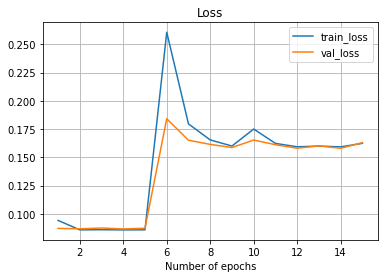

In [72]:
plot_history(hist)

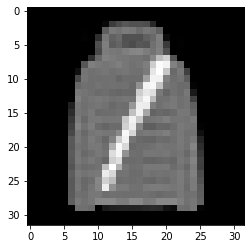

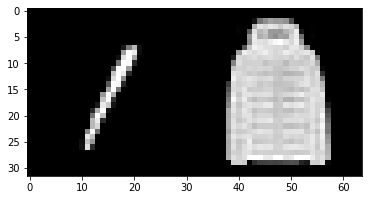

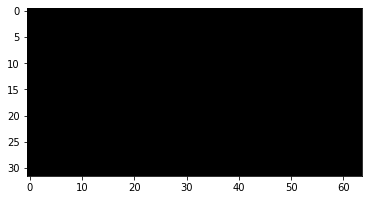

In [73]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

No good

### Further more complex network
Since now we have used a CNN autoencoder with one encoding part and two decoding parts. Now we use two completely separate CNN autoencoders.

In [86]:
from tensorflow.keras.layers import concatenate

In [87]:
def build_cnn_autoencoder(input):
  # Shape 32*32*1
  xin = input

  xa = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(xin)
  xb = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(xa)
  xc = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(xb)
  # Encoding: shape 2*2*128=2048
  x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(xc)

  y = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
  y = concatenate([y,xc])  # Skip connection
  y = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(y)
  y = concatenate([y,xb])  # Skip connection
  y = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(y)
  y = concatenate([y,xa])  # Skip connection
  y = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(y)

  # Shape 32*32*1
  return y

In [88]:
# Input: 32*32*1=1024
xin = Input(shape=(w,h,1))

# CNN autoencoder for generating the MNIST image
x1 = build_cnn_autoencoder(input=xin)

# CNN autoencoder for generating the fashion MNIST image
x2 = build_cnn_autoencoder(input=xin)

# Output: 32*64*1
y = Concatenate(axis=2)([x1,x2])

nn = Model(inputs=xin, outputs=y)

In [89]:
nn.summary()

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_31 (Conv2D)             (None, 16, 16, 16)   160         ['input_10[0][0]']               
                                                                                                  
 conv2d_35 (Conv2D)             (None, 16, 16, 16)   160         ['input_10[0][0]']               
                                                                                                  
 conv2d_32 (Conv2D)             (None, 8, 8, 32)     4640        ['conv2d_31[0][0]']              
                                                                                            

In [90]:
from tensorflow.keras.optimizers import Adam

In [91]:
nn.compile(optimizer=Adam(), loss='mse')

In [92]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('CNN_improved5.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [93]:
steps_per_epoch = N_train // batchsize
val_steps = N_test // batchsize

In [94]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 11s 11ms/step - loss: 0.0547 - val_loss: 0.0498 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0486 - val_loss: 0.0492 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0480 - val_loss: 0.0490 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0477 - val_loss: 0.0483 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0476 - val_loss: 0.0480 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0475 - val_loss: 0.0481 - lr: 0.0010
Epoch 7/50
704/937 [=====================>........] - ETA: 2s - loss: 0.0474

KeyboardInterrupt: ignored

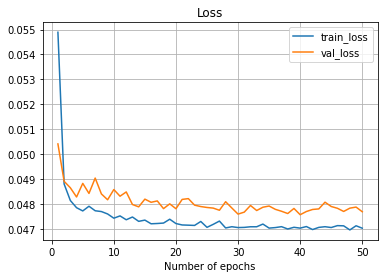

In [96]:
plot_history(hist)

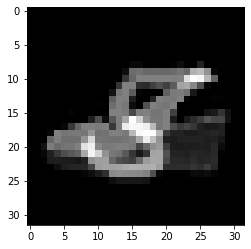

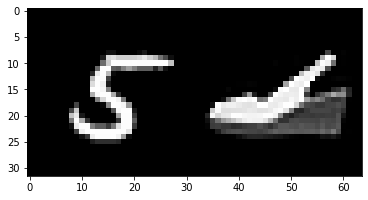

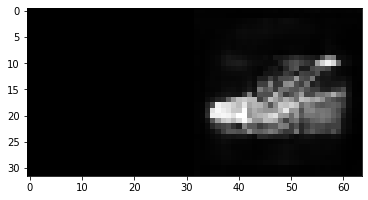

In [98]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]  # Input
y = y_batch[0]  # Ground truth
y_pred = nn.predict(x.reshape((1,32,32)))  # Prediction

plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()

No good

### Different number of batch iterations 

In [116]:
from tensorflow.keras.layers import concatenate

In [117]:
def build_cnn(input):
  xin = input

  xa = Conv2D(filters=16, kernel_size=3, strides=2, padding='same')(xin)
  xb = Conv2D(filters=32, kernel_size=3, strides=2, padding='same')(xa)
  xc = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(xb)
  # 2*2*128=2048
  x = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(xc)

  y = Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same')(x)
  y = concatenate([y,xc])
  y = Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same')(y)
  y = concatenate([y,xb])
  y = Conv2DTranspose(filters=16, kernel_size=3, strides=2, padding='same')(y)
  y = concatenate([y,xa])
  y = Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same', activation='sigmoid')(y)

  return y

In [118]:
# 32*32*1=1024
xin = Input(shape=(w,h,1))

x1 = build_cnn(input=xin)

x2 = build_cnn(input=xin)

# 32*64*1
y = Concatenate(axis=2)([x1,x2])

nn = Model(inputs=xin, outputs=y)

In [119]:
nn.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_14 (InputLayer)          [(None, 32, 32, 1)]  0           []                               
                                                                                                  
 conv2d_55 (Conv2D)             (None, 16, 16, 16)   160         ['input_14[0][0]']               
                                                                                                  
 conv2d_59 (Conv2D)             (None, 16, 16, 16)   160         ['input_14[0][0]']               
                                                                                                  
 conv2d_56 (Conv2D)             (None, 8, 8, 32)     4640        ['conv2d_55[0][0]']              
                                                                                           

In [120]:
from tensorflow.keras.optimizers import Adam

In [121]:
nn.compile(optimizer=Adam(), loss='mse')

In [122]:
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
reduce_lr_callback = ReduceLROnPlateau(monitor='val_loss', min_lr=0.000009, min_delta=0.0001, factor=0.75, patience=3, verbose=1, mode='min')
callback_checkpoint = ModelCheckpoint('CNN_improved5.{epoch:02d}-{val_loss:.4f}.hdf5', save_weights_only=True) 

In [123]:
steps_per_epoch = 1000
val_steps = 1000

In [ ]:
hist = nn.fit(train_generator, epochs=50, batch_size=batchsize, validation_data=test_generator, callbacks=[callback_checkpoint, reduce_lr_callback],
              steps_per_epoch=steps_per_epoch, validation_steps=val_steps)

Epoch 1/50
937/937 [==============================] - 11s 11ms/step - loss: 0.0547 - val_loss: 0.0498 - lr: 0.0010
Epoch 2/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0486 - val_loss: 0.0492 - lr: 0.0010
Epoch 3/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0480 - val_loss: 0.0490 - lr: 0.0010
Epoch 4/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0477 - val_loss: 0.0483 - lr: 0.0010
Epoch 5/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0476 - val_loss: 0.0480 - lr: 0.0010
Epoch 6/50
937/937 [==============================] - 10s 10ms/step - loss: 0.0475 - val_loss: 0.0481 - lr: 0.0010
Epoch 7/50
704/937 [=====================>........] - ETA: 2s - loss: 0.0474

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
def plot_history(training_history, n_epochs=None):
    if not n_epochs:
      n_epochs = len(training_history.history['loss'])

    epochs = range(1,n_epochs+1)

    plt.plot(epochs, training_history.history['loss'], label='train_loss')
    plt.plot(epochs, training_history.history['val_loss'], label='val_loss')
    plt.legend()
    plt.grid()
    plt.xlabel('Number of epochs')
    plt.title('Loss')

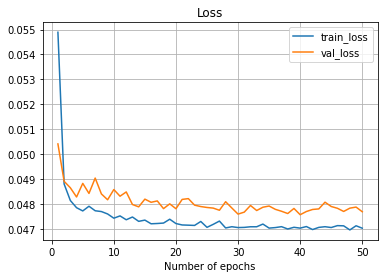

In [ ]:
plot_history(hist)

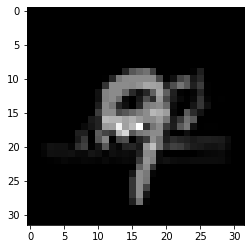

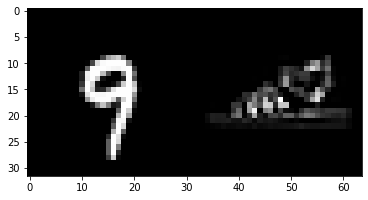

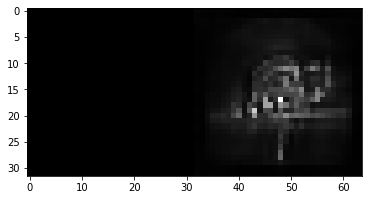

In [ ]:
x_batch, y_batch = next(test_generator)
x = x_batch[0]
y = y_batch[0]
y_pred = nn.predict(x.reshape((1,32,32)))
plt.imshow(x,cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y, cmap='gray', interpolation='nearest')
plt.show()
plt.imshow(y_pred[0].reshape((32,64)), cmap='gray', interpolation='nearest')
plt.show()